# Analysis of model convergence based on reported deaths for heavily affected countries

This notebook explores the convergence of the model on a consistant prediction as more data is fed into it.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# %matplotlib notebook

In [3]:
import os
from pathlib import Path
from matplotlib import pyplot as plt

## Method

This analysis is done by comparing the reported, modelled and forecasted deaths for 4 countries: France, Spain, Italy and the UK. These countries were picked as they present similar epidemics as judged by number of deaths. They do however present different lags with Italy's being the most advanced, followed by Spain and France, and finally followed by the UK.

Simulations provided with increasing days of reports are plotted on the same graph. "Convergence" is assessed visually by finding the point at which modelled and forecasted mean lines stop changing as more data is added.

Below are the plotting functions. In each plot data is grouped by code version and the fitting conditions. For France two fitting conditions exist:

- Fitting with influence from Europe and French regions;
- Fitting with influence from French regions only;

The effect of this difference has not been evaluated yet.

In [4]:
from model_analysis import * 

In [5]:
run_manifest = read_manifest('run-manifest.csv')
analysis_set = get_analysis_set(run_manifest)

In [6]:
analysis_set.sample()

folder version  \
101  ./runs/base-mobility-fullrun-20200528T222403-3...      v5   

    last available data  number of countries  number of zones  \
101         2020-05-16                    14               14   

                                             countries  \
101  {'Austria': True, 'Belgium': True, 'Denmark': ...   

                                       modelling zones     \
101  {'Austria': True, 'Belgium': True, 'Denmark': ...      

                                                 model  
101  <model_analysis.data_load.Model_Folder object ...

In [7]:
def group_by_version_and_country_num(df, x):
    regions = "No region"
    if df.loc[x, "number of zones"]>14:
        regions = "With regions"
    countries = "France only"
    if df.loc[x, "number of countries"]>1:
        countries = "Europe"
    JOBID = df.loc[x, "folder"][-7:-1]
    return (df.loc[x, "version"], countries, regions, JOBID)

groups = analysis_set.groupby(lambda x : group_by_version_and_country_num(analysis_set, x))



In [8]:
prop_cycle = icl_plot_core.cycler(
    linestyle=[ '-', '--'],
    marker=[' ', 'v'],
    markevery=[ 1, 4]
)
icl_plot_core.default_color_map = plt.get_cmap("viridis")

In [9]:
def plot_groups(groups, country, prop_cycle, cond_group=lambda x: True):
    for i, group in enumerate(groups):
        print(f"Plotting group {i + 1} of {len(groups)}: {group[0]}")
        if not cond_group(group[0]):
            continue
        _, ax = plt.subplots()
        ax.set_title(f"model {group[0][0]} - fitting {group[0][1]}")
        # Define Standard keyworded arguments
        standard_kwargs = {
            "ax": ax,
            "verbose": False,
        }
        # Plot data for longest data stream
        model = group[1].iloc[-1]["model"]
        plot_report_country(model.data["modelling"], country, 
            color='k', marker='o', markevery=1, linestyle='none', **standard_kwargs)
        color_cycle = define_color_cycler_from_map(group[1].shape[0])
        # For every row of each group plot the model and forecast in the same colour.
        ax.set_prop_cycle(color_cycle*prop_cycle)
        for row in group[1].iterrows():
            model = row[1]["model"]
            plot_model_country(model.data["modelling"], country, **standard_kwargs)
            plot_forecast_country(model.data["forecasting"], country, **standard_kwargs)
        # Format plots
        remove_confidence_interval_legend_labels(ax)
        modify_legend(ax, bbox_to_anchor=(1.04, 1.0), loc='upper left')
        ax.set_ylim(1, 2000)
        ax.set_yscale('log')

        axis_date_limits(ax, min_date='2020-03-10', max_date='2020-06-15')


In [10]:
def plot_groups_Rt(groups, country, prop_cycle, cond_group=lambda x: True):
    for i, group in enumerate(groups):
        print(f"Plotting group {i + 1} of {len(groups)}: {group[0]}")
        if not cond_group(group[0]):
            continue
        _, ax = plt.subplots()
        ax.set_title(f"model {group[0][0]} - fitting {group[0][1]}")
        # Define Standard keyworded arguments
        standard_kwargs = {
            "ax": ax,
            "verbose": False,
        }
        
        color_cycle = define_color_cycler_from_map(group[1].shape[0])
        # For every row of each group plot the model and forecast in the same colour.
        ax.set_prop_cycle(color_cycle*prop_cycle)
        for row in group[1].iterrows():
            model = row[1]["model"]
            plot_Rt_country(model.data["modelling"], country, **standard_kwargs)
            plot_Rt_forecast_country(
                model.data["forecasting"], country, **standard_kwargs)
        # Plot data for longest data stream
        remove_confidence_interval_legend_labels(ax)
        modify_legend(ax, bbox_to_anchor=(1.04, 1.0), loc='upper left')
        model = group[1].iloc[-1]["model"]
        plot_core.plot_interventions_countries(
            model.data["interventions"], [country], ax=ax,
            color='k',markevery=1)
        # Format plots
        # ax.set_ylim(1, 2000)
        axis_date_limits(ax, min_date='2020-02-10', max_date='2020-06-15')

In [11]:
def plot_group_Rt(group, country, prop_cycle, ax=None, min_date='2020-02-10', max_date='2020-06-15'):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title(f"Rt {group[0][0]} - fitting {group[0][1]}")
    # Define Standard keyworded arguments
    standard_kwargs = {
        "ax": ax,
        "verbose": False,
    }

    color_cycle = define_color_cycler_from_map(group[1].shape[0])
    # For every row of each group plot the model and forecast in the same colour.
    ax.set_prop_cycle(color_cycle*prop_cycle)
    for row in group[1].iterrows():
        model = row[1]["model"]
        plot_Rt_country(model.data["modelling"], country, **standard_kwargs)
        plot_Rt_forecast_country(
            model.data["forecasting"], country, **standard_kwargs)
    # Plot data for longest data stream
    remove_confidence_interval_legend_labels(ax)
    modify_legend(ax, bbox_to_anchor=(1.04, 0.7), loc='upper left')
    model = group[1].iloc[-1]["model"]
    plot_core.plot_interventions_countries(
        model.data["interventions"], [country], ax=ax,
        color='k',markevery=1)
    # Format plots
    # ax.axhline(1,color='k')
    ax.grid(which="major")
    axis_date_limits(ax, min_date=min_date, max_date=max_date)

def plot_group_deaths(group, country, prop_cycle, ax=None, min_date='2020-02-10', max_date='2020-06-15'):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title(f"model {group[0][0]} - fitting {group[0][1]}")
    # Define Standard keyworded arguments
    standard_kwargs = {
        "ax": ax,
        "verbose": False,
    }
    # Plot data for longest data stream
    model = group[1].iloc[-1]["model"]
    plot_report_country(model.data["modelling"], country, 
        color='k', marker='o', markevery=1, linestyle='none', **standard_kwargs)
    color_cycle = define_color_cycler_from_map(group[1].shape[0])
    # For every row of each group plot the model and forecast in the same colour.
    ax.set_prop_cycle(color_cycle*prop_cycle)
    for row in group[1].iterrows():
        model = row[1]["model"]
        plot_model_country(model.data["modelling"], country, **standard_kwargs)
        plot_forecast_country(model.data["forecasting"], country, **standard_kwargs)
    # Format plots
    remove_confidence_interval_legend_labels(ax)
    modify_legend(ax, bbox_to_anchor=(0.2, -0.1), loc='upper left')
    ax.set_ylim(10, 10000)
    ax.set_yscale('log')
    ax.grid(which="major")

    axis_date_limits(ax, min_date=min_date, max_date=max_date)
    
def plot_groups(groups, country, prop_cycle, cond_group=lambda x: True, min_date='2020-02-10', max_date='2020-06-15'):
    for i, group in enumerate(groups):
        if not cond_group(group[0]):
            continue
        print(f"Plotting group {i + 1} of {len(groups)}: {group[0]}")
        fig, axs = plt.subplots(1,2)
        fig.set_size_inches(15,7)
        fig.suptitle(f"{group[0]}")
        plot_group_Rt(group, country, prop_cycle, ax=axs[1], min_date=min_date, max_date=max_date)
        plot_group_deaths(group, country, prop_cycle, ax=axs[0], min_date=min_date, max_date=max_date)
        axs[0].get_legend().remove()

## Analysis of convergence on France

The next few plots display data for France as a whole modelled from a range of different dates.


Plotting group 25 of 32: (' v5', 'Europe', 'With regions', '789803')
Plotting group 26 of 32: (' v5', 'Europe', 'With regions', '790664')
Plotting group 27 of 32: (' v5', 'Europe', 'With regions', '792702')
Plotting group 30 of 32: (' v5', 'France only', 'With regions', '789805')
Plotting group 31 of 32: (' v5', 'France only', 'With regions', '790666')
Plotting group 32 of 32: (' v5', 'France only', 'With regions', '792704')


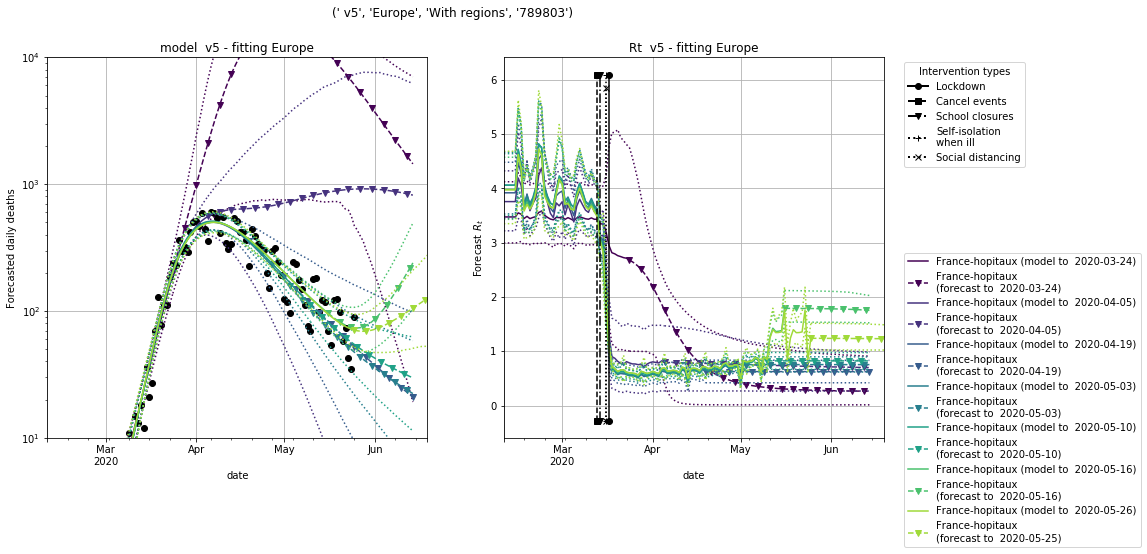

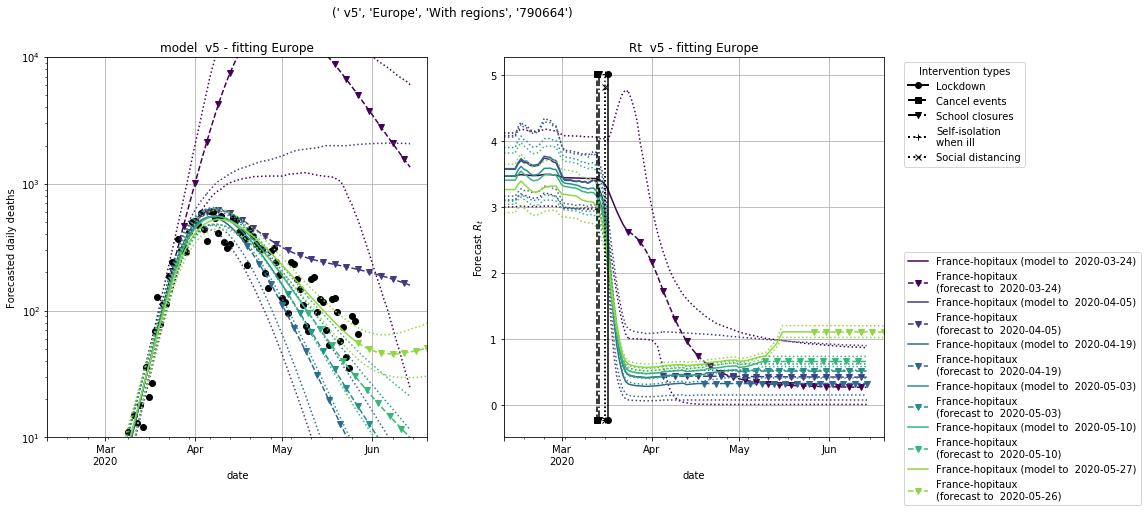

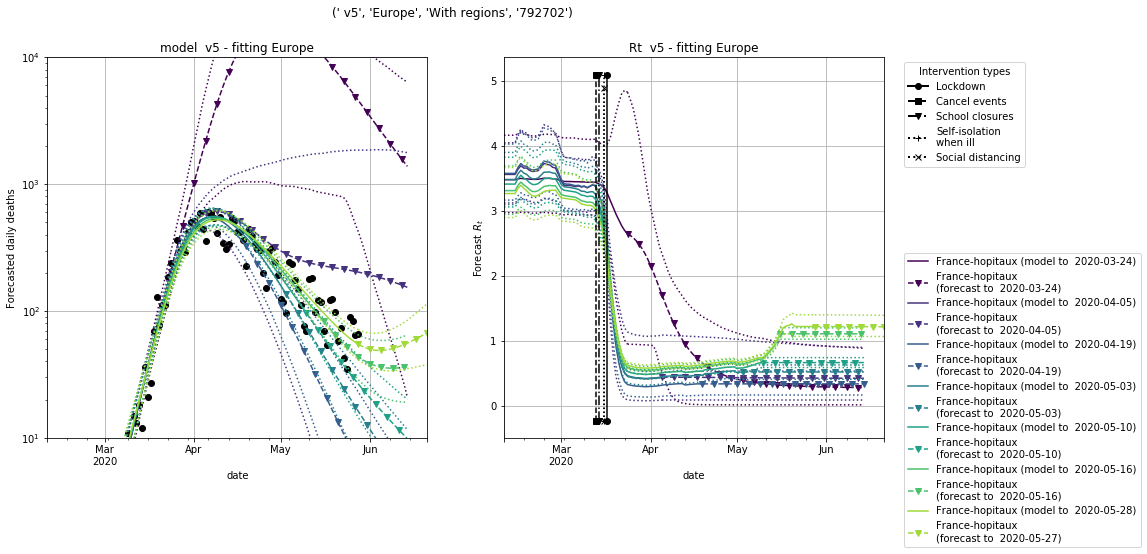

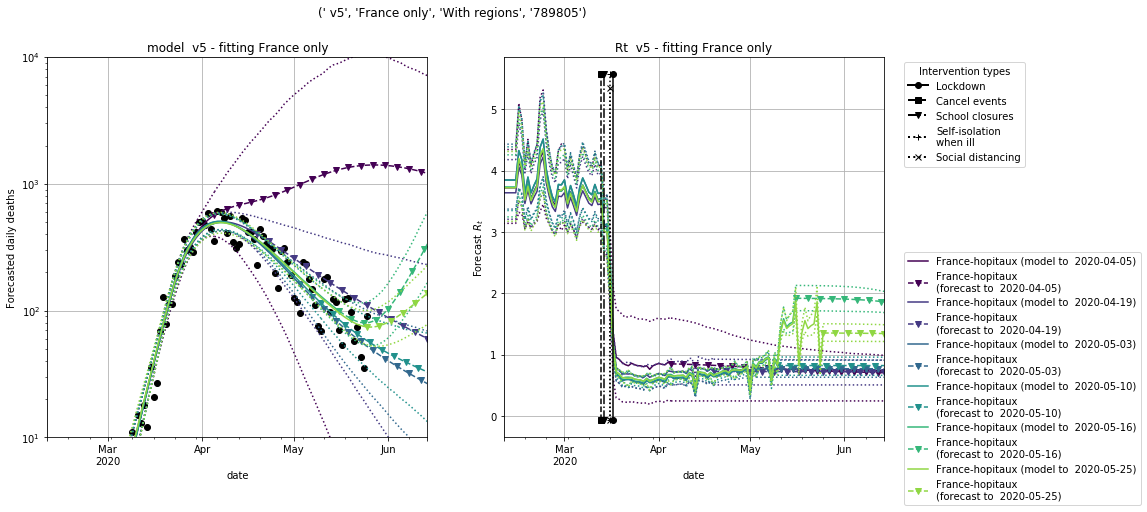

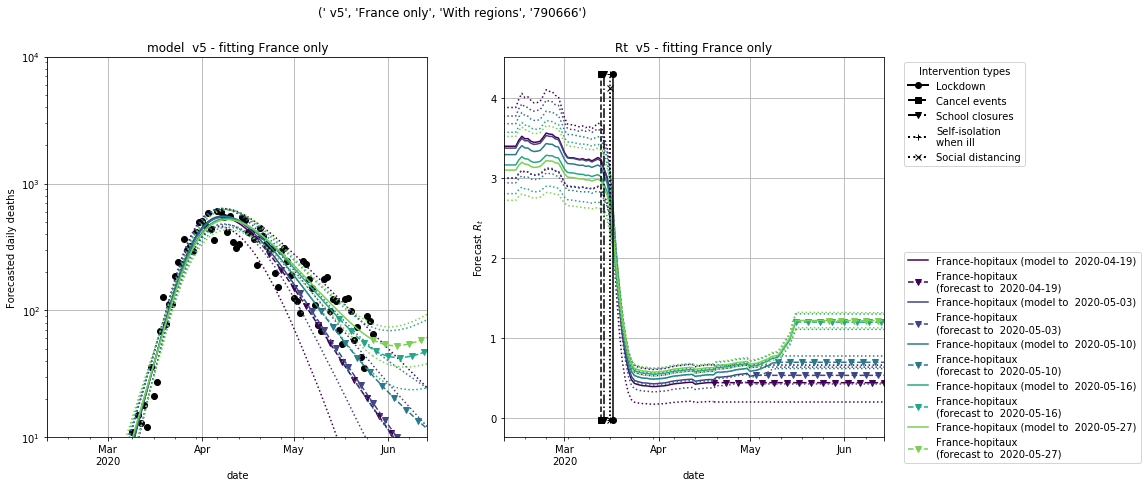

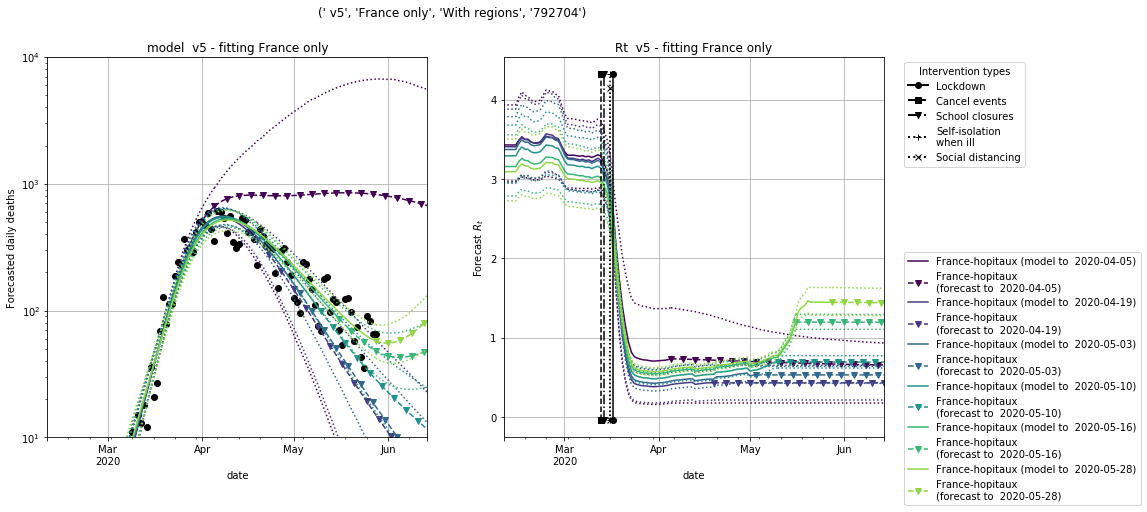

In [12]:
func = lambda x: x[2]=="With regions" and x[0].strip()=="v5"
plot_groups(groups, "France-hopitaux", prop_cycle, 
            cond_group=func, min_date='2020-02-10', max_date='2020-07-01')

## Case study of Spain, Italy and the UK



In [13]:
func = lambda x: x[1]=="Europe" and x[0].strip()=="v5" and x[2]!="With regions"

### Spain

Plotting group 21 of 32: (' v5', 'Europe', 'No region', '789804')
Plotting group 22 of 32: (' v5', 'Europe', 'No region', '789805')
Plotting group 23 of 32: (' v5', 'Europe', 'No region', '790665')
Plotting group 24 of 32: (' v5', 'Europe', 'No region', '792703')


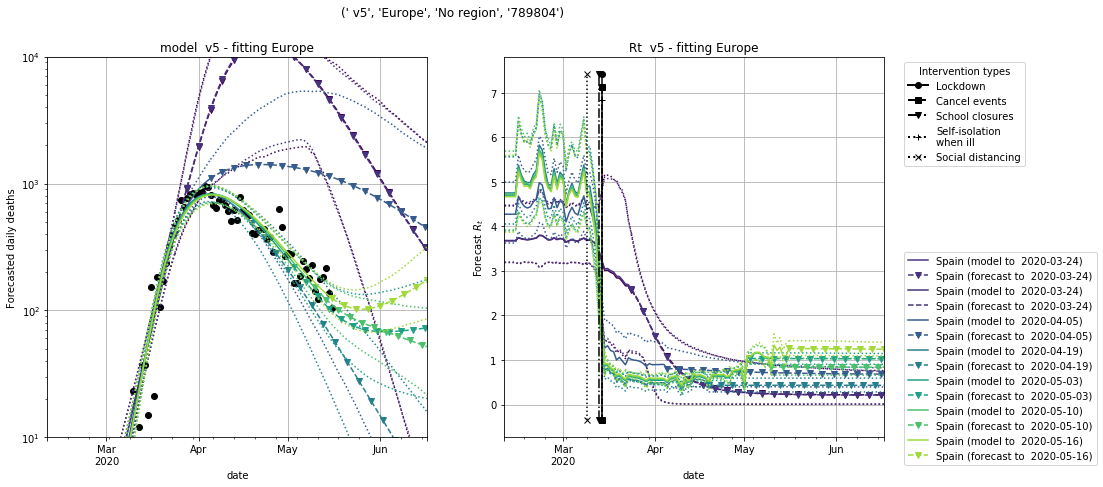

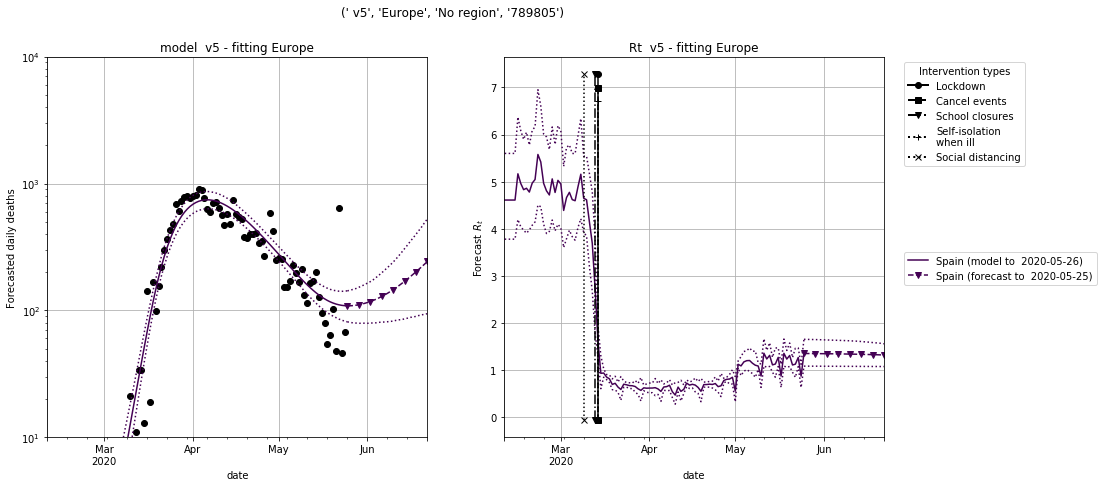

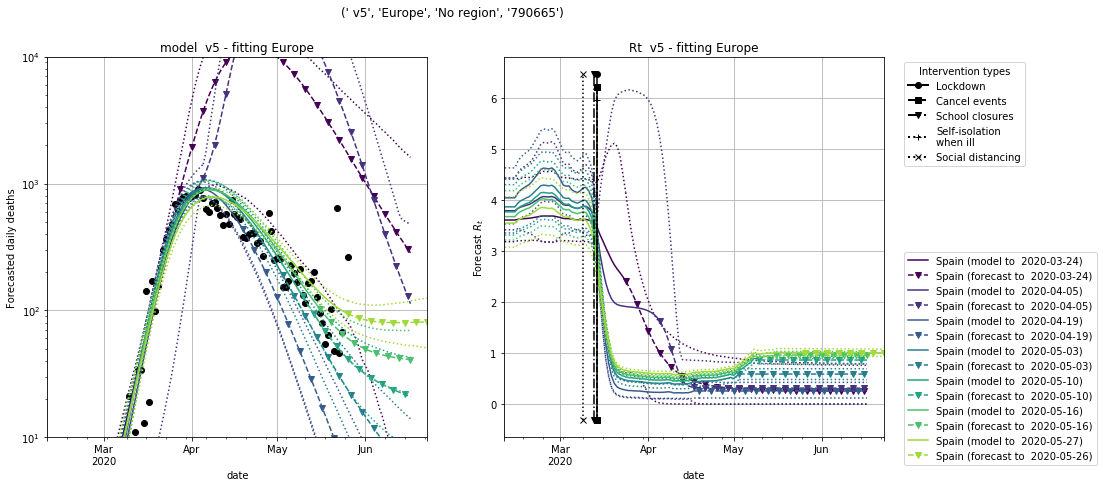

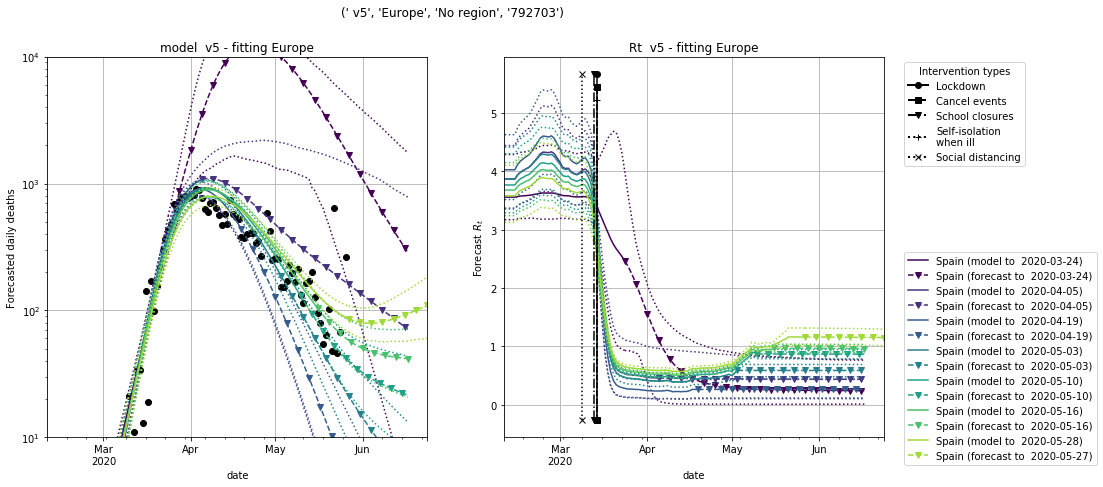

In [14]:
plot_groups(groups, "Spain", prop_cycle, 
            cond_group=func, min_date='2020-02-10', max_date='2020-07-01')

### Italy

Plotting group 21 of 32: (' v5', 'Europe', 'No region', '789804')
Plotting group 22 of 32: (' v5', 'Europe', 'No region', '789805')
Plotting group 23 of 32: (' v5', 'Europe', 'No region', '790665')
Plotting group 24 of 32: (' v5', 'Europe', 'No region', '792703')


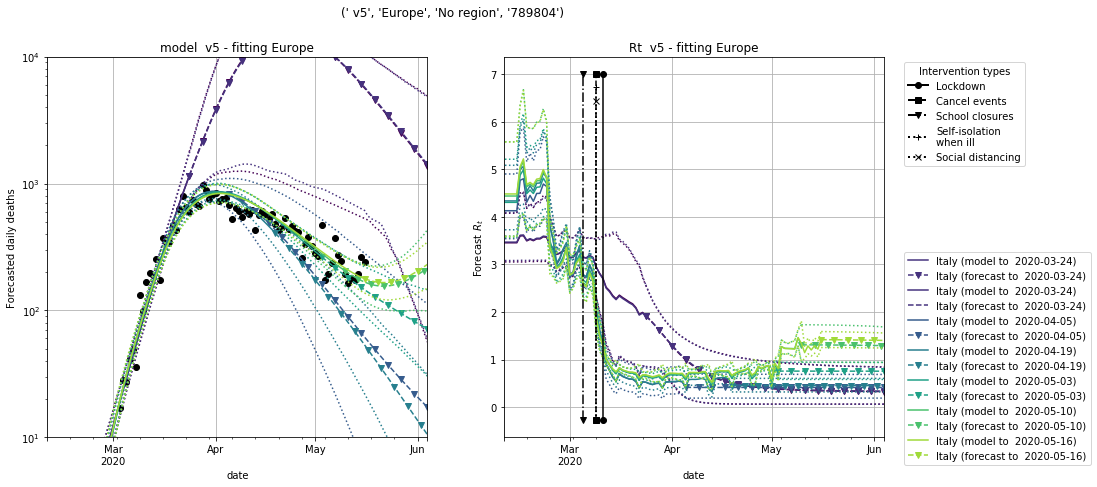

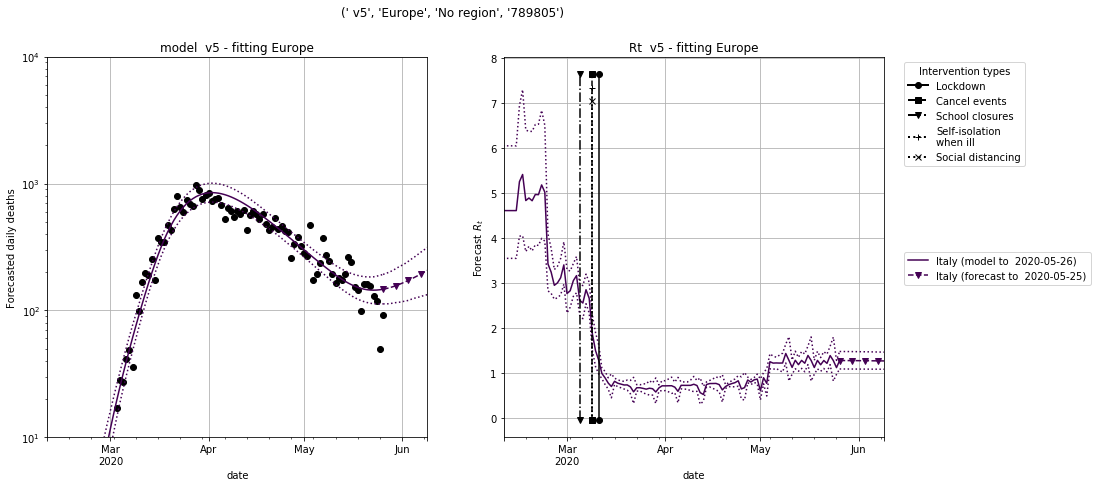

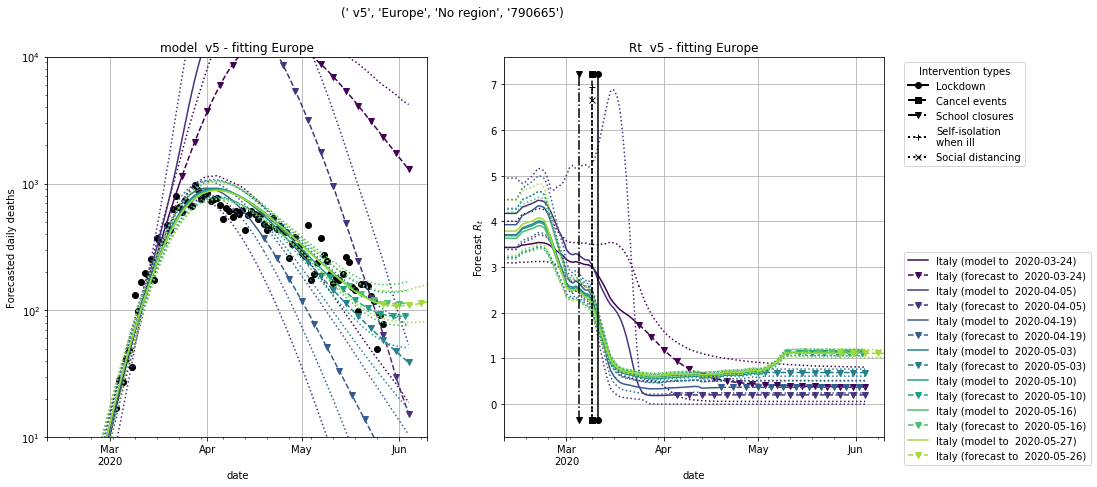

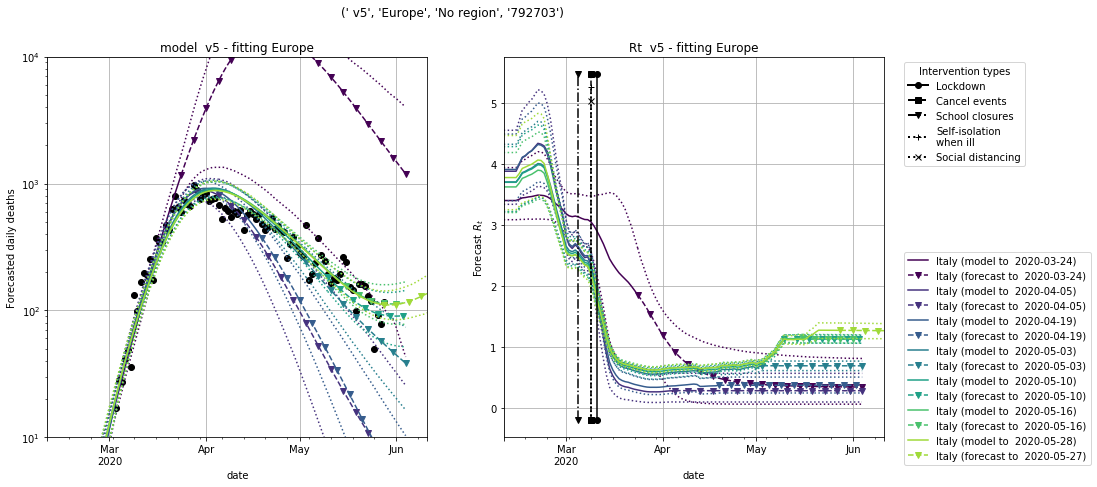

In [15]:
plot_groups(groups, "Italy", prop_cycle, 
            cond_group=func, min_date='2020-02-10', max_date='2020-07-01')

### United_Kingdom

Plotting group 21 of 32: (' v5', 'Europe', 'No region', '789804')
Plotting group 22 of 32: (' v5', 'Europe', 'No region', '789805')
Plotting group 23 of 32: (' v5', 'Europe', 'No region', '790665')
Plotting group 24 of 32: (' v5', 'Europe', 'No region', '792703')


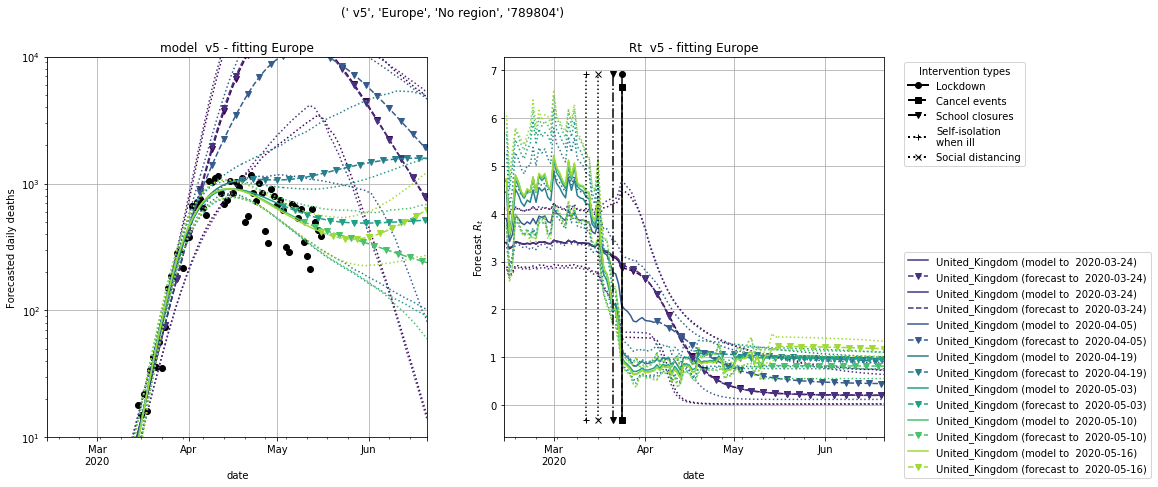

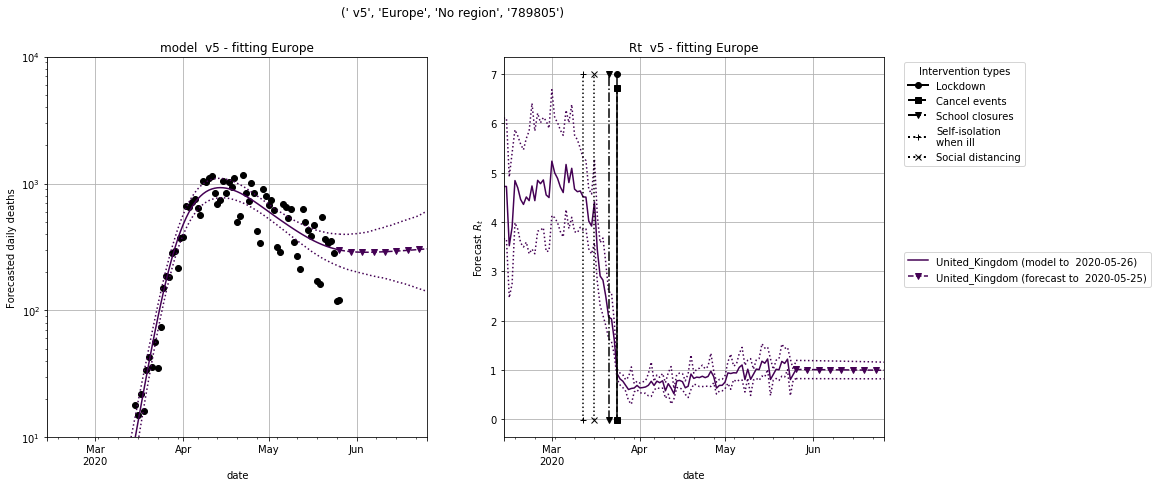

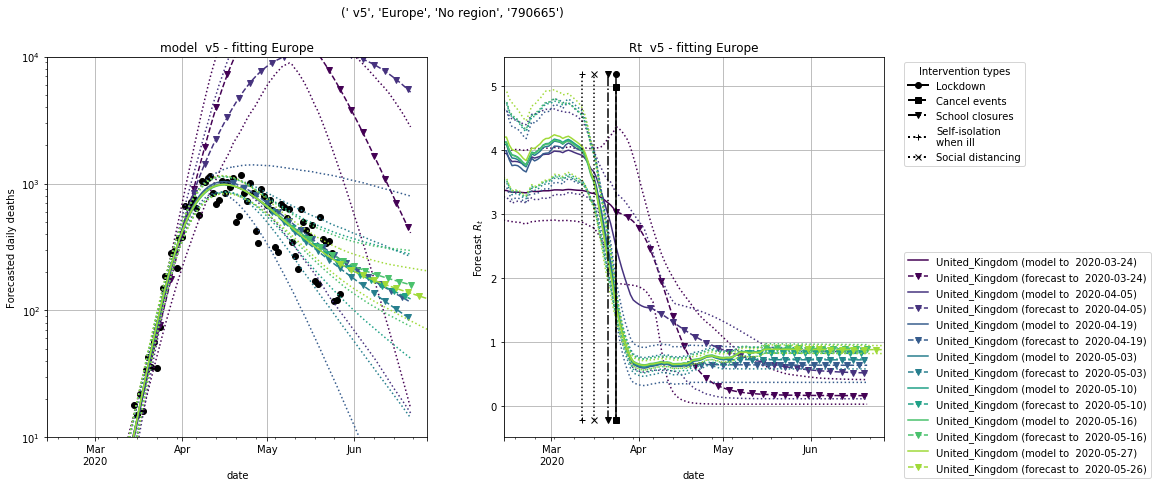

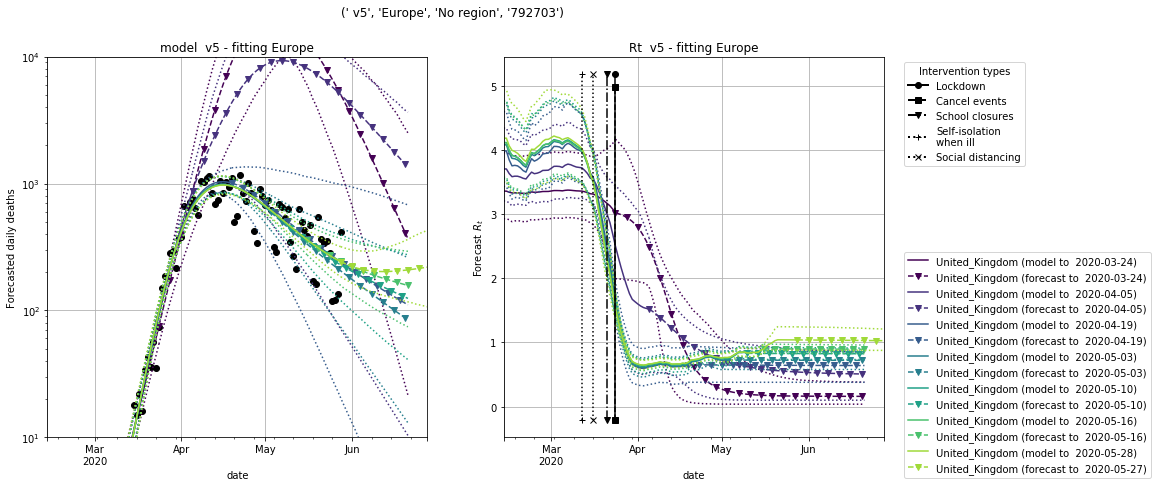

In [16]:
plot_groups(groups, "United_Kingdom", prop_cycle, 
            cond_group=func, min_date='2020-02-10', max_date='2020-07-01')

## Conclusions



### Note on convergence



### Future works



## Acknowledgements / Thanks

- The MRC at Imperial for open sourcing the model and their support
- [Nathan Desdouits](https://github.com/nathan-tc) for his advice on cleaning up the colours of the plots.